A Support Vector Machine (SVM) is a powerful and versatile Machine Learning model, capable of performing linear or nonlinear classification, regression, and even outlier detection. It is one of the most popular models in Machine Learning, and anyone interested in Machine Learning should have it in their toolbox. SVMs are particularly well suited for classification of complex small- or medium-sized datasets.

# Linear SVM Classification

The fundamental idea behind SVMs is best explained with some pictures. Figure 5-1 shows part of the iris dataset that was introduced at the end of Chapter 4. The two classes can clearly be separated easily with a straight line (they are linearly separable). The left plot shows the decision boundaries of three possible linear classifiers. The model whose decision boundary is represented by the dashed line is so bad that it does not even separate the classes properly. The other two models work perfectly on this training set, but their decision boundaries come so close to the instances that these models will probably not perform as well on new instances. In contrast, the solid line in the plot on the right represents the decision boundary of an SVM classifier; this line not only separates the two classes but also stays as far away from the closest training instances as possible. You can think of an SVM classifier as fitting the widest possible street (represented by the parallel dashed lines) between the classes. This is called _large margin classification_.

![Figure 5-1](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0501.png)

Notice that adding more training instances “off the street” will not affect the decision boundary at all: it is fully determined (or “supported”) by the instances located on the edge of the street. These instances are called the _support vectors_ (they are circled in Figure 5-1).

![Figure 5-2](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0502.png)

- **WARNING** SVMs are sensitive to the feature scales, as you can see in Figure 5-2: in the left plot, the vertical scale is much larger than the horizontal scale, so the widest possible street is close to horizontal. After feature scaling (e.g., using Scikit-Learn’s StandardScaler), the decision boundary in the right plot looks much better.

# Soft Margin Classification

If we strictly impose that all instances must be off the street and on the correct side, this is called _hard margin 
classification_. There are two main issues with hard margin classification.
 
First, it only works if the data is linearly separable. Second, it is sensitive to outliers. Figure 5-3 shows the iris dataset with just one additional outlier: on the left, it is impossible to find a hard margin; on the right, the decision boundary ends up very different from the one we saw in Figure 5-1 without the outlier, and it will probably not generalize as well.

![Figure 5-3](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0503.png)

To avoid these issues, use a more flexible model. The objective is to find a good balance between keeping the street as large as possible and limiting the margin violations (i.e., instances that end up in the middle of the street or even on the wrong side). This is called _soft margin classification_.

When creating an SVM model using Scikit-Learn, we can specify a number of hyperparameters. C is one of those hyperparameters. If we set it to a low value, then we end up with the model on the left of Figure 5-4. With a high value, we get the model on the right. Margin violations are bad. It’s usually better to have few of them. However, in this case the model on the left has a lot of margin violations but will probably generalize better.

![Figure 5-4](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0504.png)

- **TIP**: If your SVM model is overfitting, you can try regularizing it by reducing C.

 The following Scikit-Learn code loads the iris dataset, scales the features, and then trains a linear SVM model (using the LinearSVC class with C=1 and the hinge loss function, described shortly) to detect Iris virginica flowers:

In [2]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge")),
    ])

svm_clf.fit(X, y)
#This model is represented on the left of Figure 5-4.

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [3]:
# Then, as usual, you can use the model to make predictions:
svm_clf.predict([[5.5, 1.7]])

array([1.])

- **NOTE**: Unlike Logistic Regression classifiers, SVM classifiers do not output probabilities for each class.

Instead of using the LinearSVC class, we could use the SVC class with a linear kernel. When creating the SVC model, we would write **SVC(kernel="linear", C=1)**

Or we could use the SGDClassifier class, with **SGDClassifier(loss="hinge", alpha=1/(m*C))**

This applies regular Stochastic Gradient Descent to train a linear SVM classifier. It does not converge as fast as the LinearSVC class, but it can be useful to handle online classification tasks or huge datasets that do not fit in memory (out-of-core training).

- **TIP**: The LinearSVC class regularizes the bias term, so you should center the training set first by subtracting its mean. This is automatic if you scale the data using the StandardScaler. Also make sure you set the loss hyperparameter to "hinge", as it is not the default value. Finally, for better performance, you should set the dual hyperparameter to False, unless there are more features than training instances (we will discuss duality later in the chapter).

# Nonlinear SVM Classification

Although linear SVM classifiers are efficient and work surprisingly well in many cases, many datasets are not even close to being linearly separable. One approach to handling nonlinear datasets is to add more features, such as polynomial features; in some cases this can result in a linearly separable dataset. Consider the left plot in Figure 5-5: it represents a simple dataset with just one feature, $x_1$. This dataset is not linearly separable, as you can see. But if you add a second feature $x_2 = (x_1)^2$, the resulting 2D dataset is perfectly linearly separable.

![Figure 5-5](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0505.png)

To implement this idea using Scikit-Learn, create a Pipeline containing a PolynomialFeatures transformer followed by a StandardScaler and a LinearSVC. Let’s test this on the moons dataset: this is a toy dataset for binary classification in which the data points are shaped as two interleaving half circles (see Figure 5-6). You can generate this dataset using the make_moons() function:

C:\Users\JungleBook\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


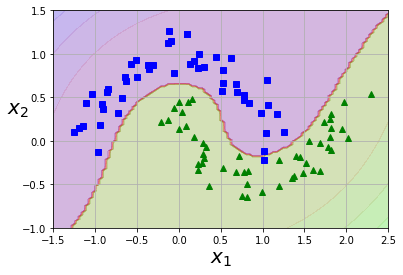

In [7]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

#generate ds 
X, y = make_moons(n_samples=100, noise=0.15) 

#Pipeline a transformer 
polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge"))
    ])

#Train the model
polynomial_svm_clf.fit(X, y)

#Clf is a trained classifier 
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

    
plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

# Polynomial Kernel

Adding polynomial features is simple to implement and can work great with all sorts of Machine Learning algorithms (not just SVMs). That said, at a low polynomial degree, this method cannot deal with very complex datasets, and with a high polynomial degree it creates a huge number of features, making the model too slow.

Fortunately, when using SVMs you can apply an almost miraculous mathematical technique called the kernel trick (explained in a moment). The kernel trick makes it possible to get the same result as if you had added many polynomial features, even with very high-degree polynomials, without actually having to add them. So there is no combinatorial explosion of the number of features because you don’t actually add any features. This trick is implemented by the SVC class. Let’s test it 
on the moons dataset:

In [8]:
from sklearn.svm import SVC
poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, break_ties=False, cache_size=200, class_weight=None,
                     coef0=1, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

This code trains an SVM classifier using a third-degree polynomial kernel. It is represented on the left in Figure 5-7. On the right is another SVM classifier using a 10th-degree polynomial kernel. Obviously, if your model is overfitting, you might want to reduce the polynomial degree. Conversely, if it is underfitting, you can try increasing it. The hyperparameter coef0 controls how much the model is influenced by high-degree polynomials versus low-degree polynomials.

![Figure 5-7](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0507.png)

- **TIP**: A common approach to finding the right hyperparameter values is to use grid search (see Chapter 2). It is often faster to first do a very coarse grid search, then a finer grid search around the best values found. Having a good sense of what each hyperparameter actually does can also help you search in the right part of the hyperparameter space.

# Similarity Features

Another technique to tackle nonlinear problems is to add features computed using a similarity function, which measures how much each instance resembles a particular landmark. For example, let’s take the 1D dataset discussed earlier and add two landmarks to it at $x_1 = –2$ and $x_1 = 1$ (see the left plot in Figure 5-8). Next, let’s define the similarity function to be the Gaussian Radial Basis Function (RBF) with $\gamma = 0.3$ (see Equation 5-1).

Eqn 5-1 
$$
\phi_{\gamma}(\mathbf{x}, \ell)=\exp \left(-\gamma\|\mathbf{x}-\ell\|^{2}\right)
$$

This is a bell-shaped function varying from 0 (very far away from the landmark) to 1 (at the landmark). Now we are ready to compute the new features. For example, let’s look at the instance $x_1 = –1$: it is located at a distance of 1 from the first landmark and 2 from the second landmark. Therefore its new features are $x_2 = \exp(–0.3 × 12) \approx 0.74 $and $x_3 = \exp(–0.3 × 22) \approx 0.30$. The plot on the right in Figure 5-8 shows the transformed dataset (dropping the original features). As you can see, it is now linearly separable.

![Figure 5-8](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0508.png)

You may wonder how to select the landmarks. The simplest approach is to create a landmark at the location of each and every instance in the dataset. Doing that creates many dimensions and thus increases the chances that the transformed training set will be linearly separable. The downside is that a training set with m instances and n features gets transformed into a training set with m instances and m features (assuming you drop the original features). If your training set is very large, you end up with an equally large number of features.

# Gaussian RBF Kernel

Just like the polynomial features method, the similarity features method can be useful with any Machine Learning algorithm, but it may be computationally expensive to compute all the additional features, especially on large training sets. Once again the kernel trick does its SVM magic, making it possible to obtain a similar result as if you had added many similarity features. Let’s try the SVC class with the Gaussian RBF kernel:

In [9]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=0.001, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=5,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

This model is represented at the bottom left in Figure 5-9. The other plots show models trained with different values of hyperparameters gamma (γ) and C. Increasing gamma makes the bell-shaped curve narrower (see the lefthand plots in Figure 5-8). As a result, each instance’s range of influence is smaller: the decision boundary ends up being more irregular, wiggling around individual instances. Conversely, a small gamma value makes the bell-shaped curve wider: instances have a larger range of influence, and the decision boundary ends up smoother. So γ acts like a regularization hyperparameter: if your model is overfitting, you should reduce it; if it is underfitting, you should increase it (similar to the C hyperparameter).

![Figure 5-9](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0509.png)

Other kernels exist but are used much more rarely. Some kernels are specialized for specific data structures. _String kernels_ are sometimes used when classifying text documents or DNA sequences (e.g., using the string subsequence kernel or kernels based on the Levenshtein distance).

- **TIP**: With so many kernels to choose from, how can you decide which one to use? As a rule of thumb, you should always try the linear kernel first (remember that LinearSVC is much faster than SVC(kernel="linear")), especially if the training set is very large or if it has plenty of features. If the training set is not too large, you should also try the Gaussian RBF kernel; it works well in most cases. Then if you have spare time and computing power, you can experiment with a few other kernels, using cross-validation and grid search. You’d want to experiment like that especially if there are kernels specialized for your training set’s data structure.

# Computational Complexity

The LinearSVC class is based on the liblinear library, which implements an optimized algorithm for linear SVMs. It does not support the kernel trick, but it scales almost linearly with the number of training instances and the number of features. Its training time complexity is roughly $O(m × n)$.

The algorithm takes longer if you require very high precision. This is controlled by the tolerance hyperparameter ϵ (called tol in Scikit-Learn). In most classification tasks, the default tolerance is fine.

The SVC class is based on the libsvm library, which implements an algorithm that supports the kernel trick. The training time complexity is usually between $O(m^2 × n)$ and $O(m^3 × n)$. Unfortunately, this means that it gets dreadfully slow when the number of training instances gets large (e.g., hundreds of thousands of instances). This algorithm is perfect for complex small or medium-sized training sets. It scales well with the number of features, especially with sparse features (i.e., when each instance has few nonzero features). In this case, the algorithm scales roughly with the average number of nonzero features per instance. Table 5-1 compares Scikit-Learn’s SVM classification classes.


|Class|	Time complexity |	Out-of-core support	| Scaling required	| Kernel trick| 
|-----|	--------------- |	------------------- |---------------	| ------------|
|LinearSVC|O(m × n) |	No | yes	| No|
|SGDClassifier|	O(m × n)|yes|yes| no|
|SVC | O(m² × n) to O(m³ × n) |no|yes| yes|


# SVM Regression
As mentioned earlier, the SVM algorithm is versatile: not only does it support linear and nonlinear classification, but it also supports linear and nonlinear regression. To use SVMs for regression instead of classification, the trick is to reverse the objective: instead of trying to fit the largest possible street between two classes while limiting margin violations, SVM Regression tries to fit as many instances as possible on the street while limiting margin violations (i.e., instances off the street). The width of the street is controlled by a hyperparameter, ϵ. Figure 5-10 shows two linear SVM Regression models trained on some random linear data, one with a large margin (ϵ = 1.5) and the other with a small margin (ϵ = 0.5).

![Figure 5-10](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0510.png)

Adding more training instances within the margin does not affect the model’s predictions; thus, the model is said to be ϵ-insensitive.

You can use Scikit-Learn’s LinearSVR class to perform linear SVM Regression. The following code produces the model represented on the left in Figure 5-10 (the training data should be scaled and centered first):



In [10]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5)
svm_reg.fit(X, y)

LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

To tackle nonlinear regression tasks, you can use a kernelized SVM model. Figure 5-11 shows SVM Regression on a random quadratic training set, using a second-degree polynomial kernel. There is little regularization in the left plot (i.e., a large C value), and much more regularization in the right plot (i.e., a small C value).

![Figure 5-11](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0511.png)

In [11]:
#The following code uses Scikit-Learn’s SVR class (which supports the kernel trick) to produce 
# the model represented on the left in Figure 5-11`
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X, y)

SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

The SVR class is the regression equivalent of the SVC class, and the LinearSVR class is the regression equivalent of the LinearSVC class. The LinearSVR class scales linearly with the size of the training set (just like the LinearSVC class), while the SVR class gets much too slow when the training set grows large (just like the SVC class).

- **NOTE**: SVMs can also be used for outlier detection; see Scikit-Learn’s documentation for more details.

# Under the Hood

First, a word about notations. In Chapter 4 we used the convention of putting all the model parameters in one vector θ, including the bias term $θ_0$ and the input feature weights $θ_1$ to $θ_n$, and adding a bias input $x_0 = 1$ to all instances. In this chapter we will use a convention that is more convenient (and more common) when dealing with SVMs: the bias term will be called b, and the feature weights vector will be called w. No bias feature will be added to the input feature vectors.

# Decision Function and Predictions

The linear SVM classifier model predicts the class of a new instance x by simply computing the decision function $W^TX+b = w_1x_1 + w_2x_2 + ... + w_nx_n + b$. If the  If the result is positive, the predicted class $\hat{y}$ is the positive class (1), and otherwise it is the negative class (0);

Eqn 5-2
$$ \hat{y} = 
\begin{cases} 
      0 & \text{ if } \space W^TX+b < 0 \\
      1 & \text{ if } \space W^TX+b \geq 0 \\
\end{cases}
$$

Figure 5-12 shows the decision function that corresponds to the model in the right in Figure 5-4: it is a 2D plane because this dataset has two features (petal width and petal length). The decision boundary is the set of points where the decision function is equal to 0: it is the intersection of two planes, which is a straight line (represented by the thick solid line).

![Figure 5-12](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0512.png)

The dashed lines represent the points where the decision function is equal to 1 or –1: they are parallel and at equal distance to the decision boundary, and they form a margin around it. Training a linear SVM classifier means finding the values of w and b that make this margin as wide as possible while avoiding margin violations (hard margin) or limiting them (soft margin).

# Training Objective

Consider the slope of the decision function: it is equal to the norm of the weight vector, ∥ w ∥. If we divide this slope by 2, the points where the decision function is equal to ±1 are going to be twice as far away from the decision boundary. In other words, dividing the slope by 2 will multiply the margin by 2. This may be easier to visualize in 2D, as shown in Figure 5-13. The smaller the weight vector w, the larger the margin.

![Figure 5-13](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0513.png)

So we want to minimize ∥ w ∥ to get a large margin. If we also want to avoid any margin violations (hard margin), then we need the decision function to be greater than 1 for all positive training instances and lower than –1 for negative training instances. If we define $t^{(i)} = –1$ for negative instances (if $y^{(i)} = 0$) and $t^{(i)} = 1$ for positive instances (if $y^{(i)} = 1$), then we can express this constraint as $t^{(i)}(w^⊺ x^{(i)} + b) ≥ 1$ for all instances.

We can therefore express the hard margin linear SVM classifier objective as the constrained optimization problem in Equation 5-3.

Eqn 5-3 
$$
\begin{aligned}
\underset{\mathbf{w}, b}{\operatorname{minimize}} &  \quad \frac{1}{2} \mathbf{w}^{\top} \mathbf{w} \\
\text { subject to } & \quad t^{(i)}\left(\mathbf{w}^{\top} \mathbf{x}^{(i)}+b\right) \geq 1 \quad \text { for } i=1,2, \cdots, m
\end{aligned}
$$

- **NOTE**: We are minimizing $\frac{1}{2} w^T w $, which is equal to $\frac{1}{2} \| w\|_2$, rather than minimizing $\| w\|$. Indeed,  $\frac{1}{2} \| w\|_2$ has a nice, simple derivative (it is just w), while $\| w\|$ is not differentiable at w = 0. Optimization algorithms work much better on differentiable functions.

To get the soft margin objective, we need to introduce a slack variable $\xi(i) ≥ 0$ for each instance: $\xi(i)$ measures how much the $i^{th}$ instance is allowed to violate the margin. We now have two conflicting objectives: make the slack variables as small as possible to reduce the margin violations, and make  $\frac{1}{2} w^T w $ as small as possible to increase the margin. This is where the C hyperparameter comes in: it allows us to define the tradeoff between these two objectives. This gives us the constrained optimization problem in Equation 5-4.

Eqn 5-4 Softmargin linear svm classifier
$$
\begin{aligned}
\underset{\mathbf{w}, b, \zeta}{\operatorname{minimize}} & \quad \frac{1}{2} \mathbf{w}^{\top} \mathbf{w}+C \sum_{i=1}^{m} \zeta^{(i)} \\
\text { subject to } & \quad t^{(i)}\left(\mathbf{w}^{\top} \mathbf{x}^{(i)}+b\right) \geq 1-\zeta^{(i)} \quad \text { and } \quad \zeta^{(i)} \geq 0 \text { for } i=1,2, \cdots, m
\end{aligned}
$$

# Quadratic Programming

The hard margin and soft margin problems are both convex quadratic optimization problems with linear constraints. Such problems are known as Quadratic Programming (QP) problems. Many off-the-shelf solvers are available to solve QP problems by using a variety of techniques that are outside the scope of this book.

The general problem formulation is given by Equation 5-5.

Eqn 5-5 
$$
\begin{aligned}
\underset{\mathbf{w}, b, \zeta}{\operatorname{minimize}} & \quad \frac{1}{2} p^T H p+f^⊺p \\
\text { subject to } & Ap \leq b
\end{aligned}
$$

Where 

$$ 
\begin{cases} 
      p & \text{is an} \space n_p - \text{dimensional vector} \space (n_p=\text{number of parameters}), \\ 
      H & \text{is an} \space n_p×n_p \space \text{matrix} \\
      f & \text{is an} \space n_p - \text{dimensional vector} \\
      A & \text{is an} \space n_c × n_p \text{matrix}(n_c=\text{numberof constraints}) \\
      b & \text{is an} \space n_c - \text{dimensional vector} \\
\end{cases}
$$


Note that the expression $A p ≤ b$ defines $n_c$ constraints: $p^⊺ a^{(i)} ≤ b^{(i)} \text{for} i = 1, 2, ⋯, n_c$, where $a^{(i)}$ is the vector containing the elements of the $i^{th}$ row of $A$ and $b^{(i)}$ is the $i^{th}$ element of b.

You can easily verify that if you set the QP parameters in the following way, you get the hard margin linear SVM classifier objective:

- $n_p = n + 1$, where $n$ is the number of features (the +1 is for the bias term).

- $n_c = m$, where m is the number of training instances.

- $H$ is the $n_p × n_p$ identity matrix, except with a zero in the top-left cell (to ignore the bias term).

- $f = 0$, an $n_p$-dimensional vector full of 0s.

- b = –1, an $n_c$-dimensional vector full of –1s.

- $a^{(i)} = –t^{(i)} \dot{x}^{(i)}$, where $\dot{x}^{(i)}$ is equal to $x^{(i)}$ with an extra bias feature $\dot{x}_0 = 1$.

One way to train a hard margin linear SVM classifier is to use an off-the-shelf QP solver and pass it the preceding parameters. The resulting vector $p$ will contain the bias term $b = p_0$ and the feature weights $w_i = p_i$ for $i = 1, 2, ⋯, n$. Similarly, you can use a QP solver to solve the soft margin problem (see the exercises at the end of the chapter).

To use the kernel trick, we are going to look at a different constrained optimization problem.

# The Dual Problem

Given a constrained optimization problem, known as the primal problem, it is possible to express a different but closely related problem, called its dual problem. The solution to the dual problem typically gives a lower bound to the solution of the primal problem, but under some conditions it can have the same solution as the primal problem. Luckily, the SVM problem happens to meet these conditions, so you can choose to solve the primal problem or the dual problem; both will have the same solution. Equation 5-6 shows the dual form of the linear SVM objective (if you are interested in knowing how to derive the dual problem from the primal problem, see Appendix C).

Eqn 5-6 Dual form of the linear SVM objective
$$
\begin{array}{l}
\underset{\boldsymbol{\alpha}}{\operatorname{minimize}} \quad \frac{1}{2} \sum_{i=1}^{m} \sum_{j=1}^{m} \alpha^{(i)} \alpha^{(j)} t^{(i)} t^{(j)} \mathbf{x}^{(i)^{\top}} \mathbf{x}^{(j)}-\sum_{i=1}^{m} \alpha^{(i)}\\
\text { subject to } \quad \alpha^{(i)} \geq 0 \text { for all } i=1,2, \ldots, m \text { and } \sum_{i=1}^{m} \alpha^{(i)} t^{(i)}=0
\end{array}
$$

Once you find the vector $\hat{\alpha}$ that minimizes this equation (using a QP solver), use Equation 5-7 to compute $\hat{w}$ and $\hat{b}$ that minimize the primal problem.

### Attempting to Summarize Appendix C
Using the _Lagrange multipliers_ method we can find a stationary point( a point where the partial derivative for our object function and constraints equal zero), the stationary point is important to optimizing what every it is we are working on. 

Apply the langrange method out hard margin Optimization problem we get: 

$$
\begin{array}{r}
\mathscr{L}(\mathbf{w}, b, \alpha)=\frac{1}{2} \mathbf{w}^{\top} \mathbf{w}-\sum_{i=1}^{m} \alpha^{(i)}\left(t^{(i)}\left(\mathbf{w}^{\top} \mathbf{x}^{(i)}+b\right)-1\right) \\
\text { with } \alpha^{(i)} \geq 0 \quad \text { for } i=1,2, \cdots, m
\end{array}
$$

Where:
- $t^{(i)}(w^⊺ x^{(i)} + b) ≥ 1$
- $\frac{1}{2} \mathbf{w}^{\top}w$ has a derivative. 
- $ \hat{\alpha} \geq 0 $
- Either $\hat{\alpha}=0$ or the ith constraint must be an active constraint, meaning it must hold by equality:  $t^{(i)}(w^⊺ x^{(i)} + b) ≥ 1$. This condition is called the complementary slackness condition. It implies that either $\hat{\alpha}^{(i)}=0$ or the $i^{th}$ instance lies on the boundary (it is a support vector).

With this we can now take the parital deriviates which give us 
$$
\begin{array}{r}
\nabla_{\mathbf{w}} \mathscr{L}(\mathbf{w}, b, \alpha)=\mathbf{w}-\sum_{i=1}^{m} \alpha^{(i)} t^{(i)} \mathbf{x}^{(i)} \\
\frac{\partial}{\partial b} \mathscr{L}(\mathbf{w}, b, \alpha)=-\sum_{i=1}^{m} \alpha^{(i)} t^{(i)}
\end{array}
$$

Now setting the partials equal to zero we have 

$$
\begin{aligned}
\widehat{\mathbf{w}}=& \sum_{i=1}^{m} \widehat{\alpha}^{(i)} t^{(i)} \mathbf{x}^{(i)} \\
& \sum_{i=1}^{m} \widehat{\alpha}^{(i)} t^{(i)}=0
\end{aligned}
$$

If we expand the generalized lagrange equation and substitute our optimized properties(the ones with the hats)

We arrive at the duality equation. 
$$
\begin{array}{l}
\mathscr{L}(\widehat{\mathbf{w}}, \widehat{\mathbf{b}}, \boldsymbol{\alpha})=\sum_{i=1}^{m} \alpha^{(i)}-\frac{1}{2} \sum_{i=1}^{m} \sum_{j=1}^{m} \alpha^{(i)} \alpha^{(j)} t^{(i)} t^{(j)} \mathbf{x}^{(i) \top} \mathbf{x}^{(j)} \\
\text { subject to } \alpha^{(i)} \geq 0 \text { for } i=1,2, \ldots, m \text { and } \sum_{i=1}^{m} \alpha^{(i)} t^{(i)}=0
\end{array}
$$

From there we find an $\hat{\alpha}$ that minimizes the objective function 

To compute the bias term we can use 

$$\hat{b}=\frac{1}{n_{s}} \sum_{i=1}^{m}\left[t^{(i)}-\widehat{\mathbf{w}}^{\top} \mathbf{x}^{(i)}\right]$$

Where ns is the number of support vectors.

The dual problem is faster to solve than the primal one when the number of training instances is smaller than the number of features. More importantly, the dual problem makes the kernel trick possible, while the primal does not. So what is this kernel trick, anyway?

# Kernelized SVMs

Suppose you want to apply a second-degree polynomial transformation to a two-dimensional training set (such as the moons training set), then train a linear SVM classifier on the transformed training set. Equation 5-8 shows the second-degree polynomial mapping function $\phi$ that you want to apply.

Eqn 5-9:Second Degree Polynomial Mapping 

$$
\phi(\mathbf{x})=\phi\left(\left(\begin{array}{c}
x_{1} \\
x_{2}
\end{array}\right)\right)=\left(\begin{array}{c}
x_{1}^{2} \\
\sqrt{2} x_{1} x_{2} \\
x_{2}{ }^{2}
\end{array}\right)
$$ 

Notice that the transformed vector is 3D instead of 2D. Now let’s look at what happens to a couple of 2D vectors, a and b, if we apply this second-degree polynomial mapping and then compute the dot product of the transformed vectors

Eqn 5-9: Kernal trick for a second degree polynomial mapping. 
$$
\begin{aligned}
\phi(\mathbf{a})^{\top} \phi(\mathbf{b}) &=\left(\begin{array}{c}
a_{1}^{2} \\
\sqrt{2} a_{1} a_{2} \\
a_{2}^{2}
\end{array}\right)^{\top}\left(\begin{array}{c}
b_{1}^{2} \\
\sqrt{2} b_{1} b_{2} \\
b_{2}^{2}
\end{array}\right)=a_{1}^{2} b_{1}^{2}+2 a_{1} b_{1} a_{2} b_{2}+a_{2}^{2} b_{2}^{2} \\
=&\left(a_{1} b_{1}+a_{2} b_{2}\right)^{2}=\left(\left(\begin{array}{c}
a_{1} \\
a_{2}
\end{array}\right)^{\top}\left(\begin{array}{l}
b_{1} \\
b_{2}
\end{array}\right)\right)^{2}=\left(\mathbf{a}^{\top} \mathbf{b}\right)^{2}
\end{aligned}
$$

That is, the dot product of the transformed vectors is equal to the square of the dot product of the original vectors: $
\phi(\mathbf{a})^{\top} \phi(\mathbf{b}) = \left(\mathbf{a}^{\top} \mathbf{b}\right)^{2}$ 

Here is the key insight: if you apply the transformation $\phi$ to all training instances, then the dual problem will contain the dot product $\phi(x^{(i)})^T \phi(x^{(j)})$. But if $\phi$ is the second-degree polynomial transformation defined in Equation 5-8, then you can replace this dot product of transformed vectors simply by $ (x^{(i)^T} x^{(j)})^2 $. So, you don’t need to transform the training instances at all; just replace the dot product by its square in Equation 5-6. The result will be strictly the same as if you had gone through the trouble of transforming the training set then fitting a linear SVM algorithm, but this trick makes the whole process much more computationally efficient.

The function $K(a, b) = (a^T b)^2$ is a second-degree polynomial kernel. In Machine Learning, a kernel is a function capable of computing the dot product $\phi(a)^T \phi(b)$, based only on the original vectors a and b, without having to compute (or even to know about) the transformation $\phi.$ Equation 5-10 lists some of the most commonly used kernels

Eqn 5-10:
$$
\begin{aligned}
\text { Linear: } & K(\mathbf{a}, \mathbf{b})=\mathbf{a}^{\top} \mathbf{b} \\
\text { Polynomial: } & K(\mathbf{a}, \mathbf{b})=\left(\gamma \mathbf{a}^{\top} \mathbf{b}+r\right)^{d} \\
\text { Gaussian RBF: } & K(\mathbf{a}, \mathbf{b})=\exp \left(-\gamma\|\mathbf{a}-\mathbf{b}\|^{2}\right) \\
\text { Sigmoid: } & K(\mathbf{a}, \mathbf{b})=\tanh \left(\gamma \mathbf{a}^{\top} \mathbf{b}+r\right)
\end{aligned}
$$


---------------------------------------------------------------------------
### Mercer's Theorem 
According to Mercer’s theorem, if a function K(a, b) respects a few mathematical conditions called Mercer’s conditions (e.g., K must be continuous and symmetric in its arguments so that K(a, b) = K(b, a), etc.), then there exists a function ϕ that maps a and b into another space (possibly with much higher dimensions) such that K(a, b) = ϕ(a)⊺ ϕ(b). You can use K as a kernel because you know ϕ exists, even if you don’t know what ϕ is. In the case of the Gaussian RBF kernel, it can be shown that ϕ maps each training instance to an infinite-dimensional space, so it’s a good thing you don’t need to actually perform the mapping!

Note that some frequently used kernels (such as the sigmoid kernel) don’t respect all of Mercer’s conditions, yet they generally work well in practice.

---------------------------------------------------------------------------

There is still one loose end we must tie up. Equation 5-7 shows how to go from the dual solution to the primal solution in the case of a linear SVM classifier. But if you apply the kernel trick, you end up with equations that include ϕ(x(i)). In fact, $\hat{w}$ must have the same number of dimensions as $\phi(x(i))$, which may be huge or even infinite, so you can’t compute it. But how can you make predictions without knowing wˆ? Well, the good news is that you can plug the formula for $\hat{w}$ from Equation 5-7 into the decision function for a new instance $x^{(n)}$, and you get an equation with only dot products between input vectors. This makes it possible to use the kernel trick (Equation 5-11).

Eqn 5-11: Making prediciton with a kernelized SVM 
$$
\begin{aligned}
h_{\widehat{\mathbf{w}}, \hat{b}}\left(\phi\left(\mathbf{x}^{(n)}\right)\right) &=\widehat{\mathbf{w}}^{\top} \phi\left(\mathbf{x}^{(n)}\right)+\hat{b}=\left(\sum_{i=1}^{m} \widehat{\alpha}^{(i)} t^{(i)} \phi\left(\mathbf{x}^{(i)}\right)\right)^{\top} \phi\left(\mathbf{x}^{(n)}\right)+\hat{b} \\
&=\sum_{i=1}^{m} \widehat{\alpha}^{(i)} t^{(i)}\left(\phi\left(\mathbf{x}^{(i)}\right)^{\top} \phi\left(\mathbf{x}^{(n)}\right)\right)+\hat{b} \\
&=\sum_{i=1 \atop \hat{\alpha}^{(i)}>0}^{m} \widehat{\alpha}^{(i)} t^{(i)} K\left(\mathbf{x}^{(i)}, \mathbf{x}^{(n)}\right)+\hat{b}
\end{aligned}
$$

Note that since $\alpha^{(i)} \neq 0$ only for support vectors, making predictions involves computing the dot product of the new input vector $x^{(n)}$ with only the support vectors, not all the training instances. Of course, you need to use the same trick to compute the bias term $\hat{b}$ (Equation 5-12).

- Note: Our goal is maximize the margins or street. The streets end where our support vectors are, thus we only care about the support vectors when finding a statonary point($\alpha$). 

Equation 5-12. Using the kernel trick to compute the bias term
![Eqn 5-12](https://cdn.mathpix.com/snip/images/jb0Qk0vjFHkJVaV2C0ZzImypWBZci1DblWVfYOyNTFo.original.fullsize.png)


# Online SVMs

Before concluding this chapter, let’s take a quick look at online SVM classifiers (recall that online learning means learning incrementally

For linear SVM classifiers, one method for implementing an online SVM classifier is to use Gradient Descent (e.g., using SGDClassifier) to minimize the cost function in Equation 5-13, which is derived from the primal problem. Unfortunately, Gradient Descent converges much more slowly than the methods based on QP.

Equation 5-13. Linear SVM classifier cost function
$$
J(\mathbf{w}, b)=\frac{1}{2} \mathbf{w}^{\top} \mathbf{w} \quad+C \sum_{i=1}^{m} \max \left(0,1-t^{(i)}\left(\mathbf{w}^{\top} \mathbf{x}^{(i)}+b\right)\right)
$$

The first sum in the cost function will push the model to have a small weight vector $w$, leading to a larger margin. The second sum computes the total of all margin violations. An instance’s margin violation is equal to 0 if it is located off the street and on the correct side, or else it is proportional to the distance to the correct side of the street. Minimizing this term ensures that the model makes the margin violations as small and as few as possible.

# HINGE LOSS

The function $max(0, 1 – t)$ is called the hinge loss function (see the following image). It is equal to 0 when t ≥ 1. Its derivative (slope) is equal to $–1$ if $t < 1$ and $0$ if $t > 1$. It is not differentiable at $t = 1$, but just like for Lasso Regression (see “Lasso Regression”), you can still use Gradient Descent using any subderivative at $t = 1$ (i.e., any value between $–1$ and $0$).

![Hinge Loss](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0514.png) 

It is also possible to implement online kernelized SVMs, as described in the papers “Incremental and Decremental Support Vector Machine Learning” and “Fast Kernel Classifiers with Online and Active Learning”. These kernelized SVMs are implemented in Matlab and C++. For large-scale nonlinear problems, you may want to consider using neural networks instead.